In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools 

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('euro_exchange_rate.csv')
df.head()

,Date,USD,JPY,BGN,CYP,CZK,DKK,EEK,GBP,HUF,...,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR,Unnamed: 42
0,2023-04-12,1.0922,146.09,1.9558,NaN,23.421,7.4506,NaN,0.88038,376.23,...,89.6875,1448.10,19.7972,4.8193,1.7649,60.291,1.4538,37.391,20.1330,NaN
1,2023-04-11,1.0905,145.28,1.9558,NaN,23.469,7.4505,NaN,0.87738,375.23,...,89.5205,1441.82,19.7901,4.8184,1.7566,59.996,1.4526,37.361,19.9013,NaN
2,2023-04-06,1.0915,143.49,1.9558,NaN,23.409,7.4510,NaN,0.87495,376.10,...,89.3655,1438.81,19.9624,4.8015,1.7387,59.562,1.4507,37.171,19.8929,NaN
3,2023-04-05,1.0940,143.74,1.9558,NaN,23.429,7.4498,NaN,0.87685,376.19,...,89.7215,1434.80,19.8441,4.8120,1.7349,59.604,1.4512,37.032,19.6107,NaN
4,2023-04-04,1.0901,144.94,1.9558,NaN,23.418,7.4513,NaN,0.87333,376.83,...,89.5900,1434.69,19.6561,4.8030,1.7336,59.436,1.4467,37.314,19.4414,NaN


In [3]:
df=df.drop('Unnamed: 42', axis=1)
df.columns

Index(['Date', 'USD', 'JPY', 'BGN', 'CYP', 'CZK', 'DKK', 'EEK', 'GBP', 'HUF',
       'LTL', 'LVL', 'MTL', 'PLN', 'ROL', 'RON', 'SEK', 'SIT', 'SKK', 'CHF',
       'ISK', 'NOK', 'HRK', 'RUB', 'TRL', 'TRY', 'AUD', 'BRL', 'CAD', 'CNY',
       'HKD', 'IDR', 'ILS', 'INR', 'KRW', 'MXN', 'MYR', 'NZD', 'PHP', 'SGD',
       'THB', 'ZAR'],
      dtype='object')

In [4]:
df.isnull().sum()

Date       0
USD        0
JPY        0
BGN      398
CYP     3914
CZK        0
DKK        0
EEK     3144
GBP        0
HUF        0
LTL     2121
LVL     2376
MTL     3914
PLN        0
ROL     4554
RON     1664
SEK        0
SIT     4169
SKK     3658
CHF        0
ISK     2341
NOK        0
HRK     1670
RUB     1885
TRL     4681
TRY     1537
AUD        0
BRL     2304
CAD        0
CNY     1599
HKD        0
IDR     1599
ILS     3074
INR     2560
KRW        0
MXN     2304
MYR     1599
NZD        0
PHP     1599
SGD        0
THB     1599
ZAR        0
dtype: int64

Print full rows having NULL entries in the df

In [5]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

In [6]:
print(rows_with_NaN)

            Date     USD     JPY     BGN      CYP     CZK     DKK      EEK  \
0     2023-04-12  1.0922  146.09  1.9558      NaN  23.421  7.4506      NaN   
1     2023-04-11  1.0905  145.28  1.9558      NaN  23.469  7.4505      NaN   
2     2023-04-06  1.0915  143.49  1.9558      NaN  23.409  7.4510      NaN   
3     2023-04-05  1.0940  143.74  1.9558      NaN  23.429  7.4498      NaN   
4     2023-04-04  1.0901  144.94  1.9558      NaN  23.418  7.4513      NaN   
...          ...     ...     ...     ...      ...     ...     ...      ...   
6213  1999-01-08  1.1659  130.09     NaN  0.58187  34.938  7.4433  15.6466   
6214  1999-01-07  1.1632  129.43     NaN  0.58187  34.886  7.4431  15.6466   
6215  1999-01-06  1.1743  131.42     NaN  0.58200  34.850  7.4452  15.6466   
6216  1999-01-05  1.1790  130.96     NaN  0.58230  34.917  7.4495  15.6466   
6217  1999-01-04  1.1789  133.73     NaN  0.58231  35.107  7.4501  15.6466   

          GBP     HUF  ...     ILS      INR      KRW      MXN  

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6218 non-null   object 
 1   USD     6218 non-null   float64
 2   JPY     6218 non-null   float64
 3   BGN     5820 non-null   float64
 4   CYP     2304 non-null   float64
 5   CZK     6218 non-null   float64
 6   DKK     6218 non-null   float64
 7   EEK     3074 non-null   float64
 8   GBP     6218 non-null   float64
 9   HUF     6218 non-null   float64
 10  LTL     4097 non-null   float64
 11  LVL     3842 non-null   float64
 12  MTL     2304 non-null   float64
 13  PLN     6218 non-null   float64
 14  ROL     1664 non-null   float64
 15  RON     4554 non-null   float64
 16  SEK     6218 non-null   float64
 17  SIT     2049 non-null   float64
 18  SKK     2560 non-null   float64
 19  CHF     6218 non-null   float64
 20  ISK     3877 non-null   float64
 21  NOK     6218 non-null   float64
 22  

The values are numeric instead of objects by calling df.dtypes and pd.to_numeric for type conversion.

In [8]:
df5=df.loc[:,['Date','USD', 'JPY', 'GBP', 'AUD', 'CAD']]
df5.head()

,Date,USD,JPY,GBP,AUD,CAD
0,2023-04-12,1.0922,146.09,0.88038,1.6377,1.4728
1,2023-04-11,1.0905,145.28,0.87738,1.6387,1.4732
2,2023-04-06,1.0915,143.49,0.87495,1.6312,1.4704
3,2023-04-05,1.0940,143.74,0.87685,1.6325,1.4719
4,2023-04-04,1.0901,144.94,0.87333,1.6154,1.4641


In [9]:
df5['Date']=pd.to_datetime(df5['Date'])

### Distribution Plots

In [10]:
df5_list = ['USD', 'JPY', 'GBP', 'AUD', 'CAD']

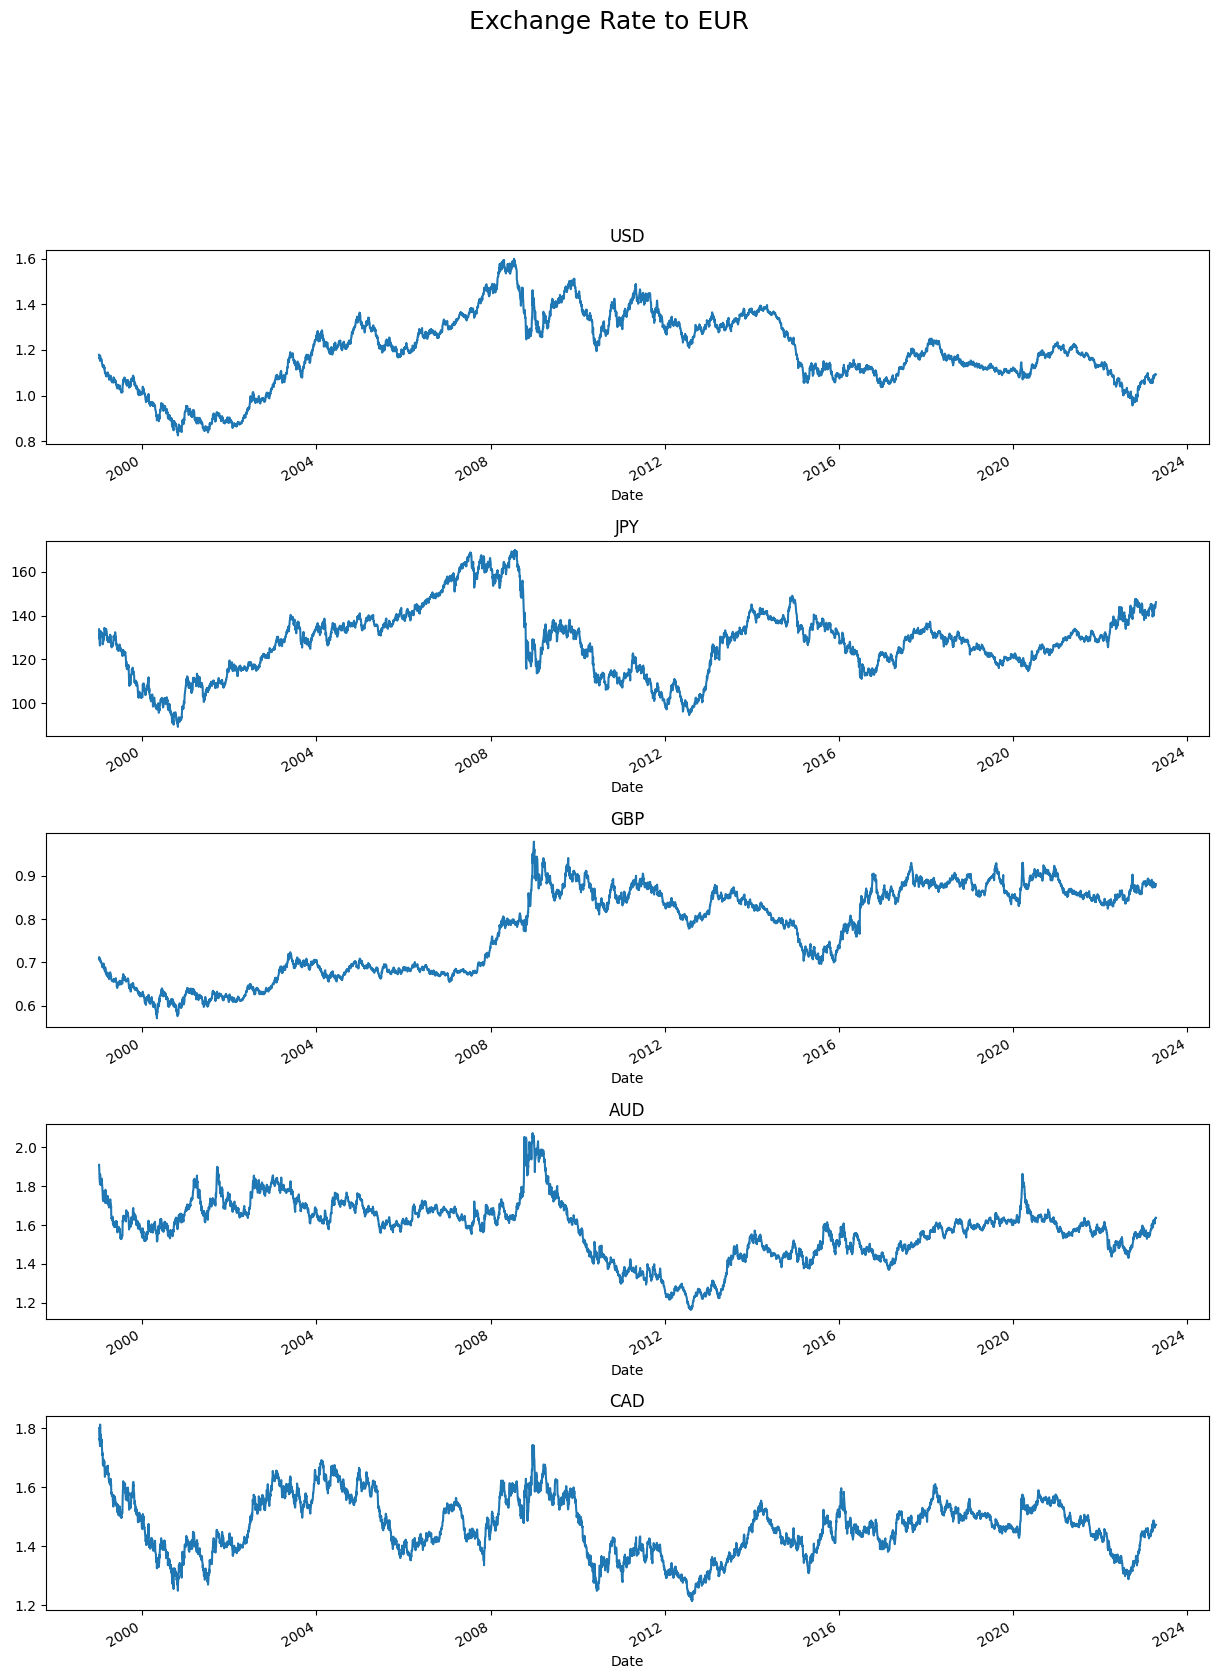

In [11]:
plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Exchange Rate to EUR', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(df5_list):
    # add new subplot iteratively
    ax = plt.subplot(5,1,n+1)
    df5.plot(x='Date',y=currency,ax=ax, legend=None)
    # chart formating
    ax.set_title(currency.upper()) 

Determine Stationarity
Is it a stationary series?

The mean of the time series should not be a finction of time. It should be constant.
The variance of the time series should not be a function of time.
The covariance of the ith term and the (i+m)th term should not be a function of time.
The statistical properties over time frame have to be constant and autocovariance must not fluctuate with time.

### Resample the data

Daily data for time series usually contains too much variation. Therefore, each series will be resampled by week. This resampled time series will be used to predict the exchange rate against the EUR.

In [12]:
# to resample the index of exchange df must be in date time
df5.set_index('Date', inplace=True)

In [13]:
# initialize an empty dataframe for the weekly sample
df5_weekly= pd.DataFrame()

Resampling the time series data based on weekly frequency <br>
Apply it on stock open price 'W' indicates week <br>
Find the mean exchange rate of each week <br>
For each week over the period 

In [14]:
for i in range(len(df5_list)):
    
    week_series = df5[df5_list[i]].resample('W').mean()
    df5_weekly[df5_list[i]] = week_series.values
    if i == len(df5_list) - 1:
        df5_weekly['Date'] = week_series.index
        df5_weekly.set_index('Date', inplace=True)
        

In [15]:
df5_weekly.head()

,USD,JPY,GBP,AUD,CAD
Date,,,,,
1999-01-10,1.17226,131.126,0.70923,1.87488,1.77850
1999-01-17,1.16224,130.466,0.70590,1.83170,1.76964
1999-01-24,1.15884,131.770,0.70110,1.82094,1.76252
1999-01-31,1.14978,132.032,0.69542,1.82740,1.74778
1999-02-07,1.13134,128.208,0.68992,1.76134,1.70138


In [16]:
df5_weekly['USD'].name

'USD'

## Stationarity Check

### Method 1: Perform the Augmented Dickey-Fuller (ADF)
We can alscheck for staionarity with statistical tests.

- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

The Dickey Fuller test is used to check the stationarity of the series. The test determines how stringly a time series is defined by a trend. The null hypothesis of the test is that time series is not stationary( has some time-dependent structure).<br>
The test result is made up of a Test Statistic and some Critical Values for different confidence levels. If P-VALUE is less than the significance level , the null hypothesis is rejected and the series is stationary.

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary.
The ADF tests give the following results – test statistic, p-value, and critical value at 1%, 5%, and 10% confidence intervals

The test result is made up of a Test Statistic and some Critical Values for different confidence levels. If P-VALUE is less than the significance level , the null hypothesis is rejected and the series is stationary.

if p_value > 0.05 and the stat_value > any of the critical values:
* Acceptiong the Null Hypothesis i.e Dataset is Non-Stationary

else:
* Rejecting the Null Hypothesis i.e Dataset is Stationary

In [17]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [18]:
#Test whether the data is stationary to be able to use ARIMA model or not

#4.1 Stationary Testing using ADF Test
#H0: Dataset is not stationary
#H1: Dataset is stationary
for n, currency in enumerate(df5_weekly): 
    print(currency)
    result = adfuller(df5_weekly[currency].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')  
        
    if result[1] > 0.05:
        print('Non-Stationary')
    else:
        print('Stationary')
    print('====================================')
        


USD
ADF Statistic: -1.840008
p-value: 0.360788
Critial Values:
   1%, -3.4355381554821585
Critial Values:
   5%, -2.8638311143598556
Critial Values:
   10%, -2.567989813198476
Non-Stationary
JPY
ADF Statistic: -2.085696
p-value: 0.250305
Critial Values:
   1%, -3.43554227494792
Critial Values:
   5%, -2.8638329319593185
Critial Values:
   10%, -2.5679907811664124
Non-Stationary
GBP
ADF Statistic: -1.393663
p-value: 0.585310
Critial Values:
   1%, -3.4355381554821585
Critial Values:
   5%, -2.8638311143598556
Critial Values:
   10%, -2.567989813198476
Non-Stationary
AUD
ADF Statistic: -2.550080
p-value: 0.103760
Critial Values:
   1%, -3.43554227494792
Critial Values:
   5%, -2.8638329319593185
Critial Values:
   10%, -2.5679907811664124
Non-Stationary
CAD
ADF Statistic: -4.090196
p-value: 0.001005
Critial Values:
   1%, -3.4355340425478706
Critial Values:
   5%, -2.863829299639741
Critial Values:
   10%, -2.5679888467643406
Stationary


The Test Statistic is -1.840008, which is greater than any of the critical values.<br>
p-value is 0.360788 <br>
The p-value obtained is greater than the significance level of 0.05, and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is, in fact, non-stationary.

### Method 2: ACF and PACF plots
ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone.
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

In [19]:
df_usd=df5_weekly['USD']
df_usd.head()

Date
1999-01-10    1.17226
1999-01-17    1.16224
1999-01-24    1.15884
1999-01-31    1.14978
1999-02-07    1.13134
Name: USD, dtype: float64

In [20]:
train_data, test_data = train_test_split(df_usd, test_size=0.05, shuffle=False)

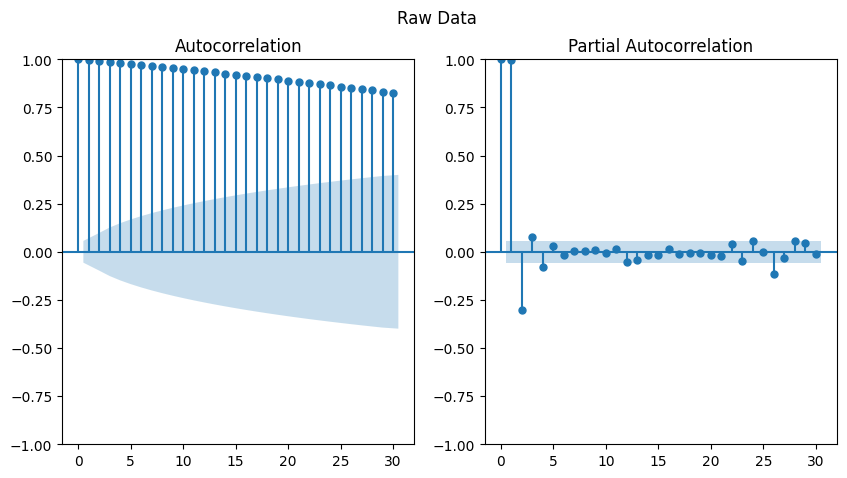

In [21]:
#ACF, PACF plot
#http://www.statmodels.org/stable/generated/statmodels.graghics.tsaplots.plot_acf.html
#http://www.statmodels.org/stable/generated/statmodels.graghics.tsaplots.plot_pacf.html

fig, ax=plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]); #Modify not to generate graph twice

ACF plot이 점직적으로 낮아지는것은 nonstationary 데이타의 특성이다 
The ACF plot shows that the correlations with the legs are high and positive with very slow decay.
While the PACF plot shows the partial autocorrelations having a single spike at leg one.
These are both signs of a well-known time series called random walk which is not stationary.

### Seasonal decomposition plot: seasonal decomposition using movning averages.
- https://www.statsmodels.org/stable/generated/statsmodels.tsa/seasonal.seasonal_decompose.html
- bserved: observed data
- Trand: The estimated trend component
- seasonal: The estimated seasonal component
- resid : The The estimated residuals

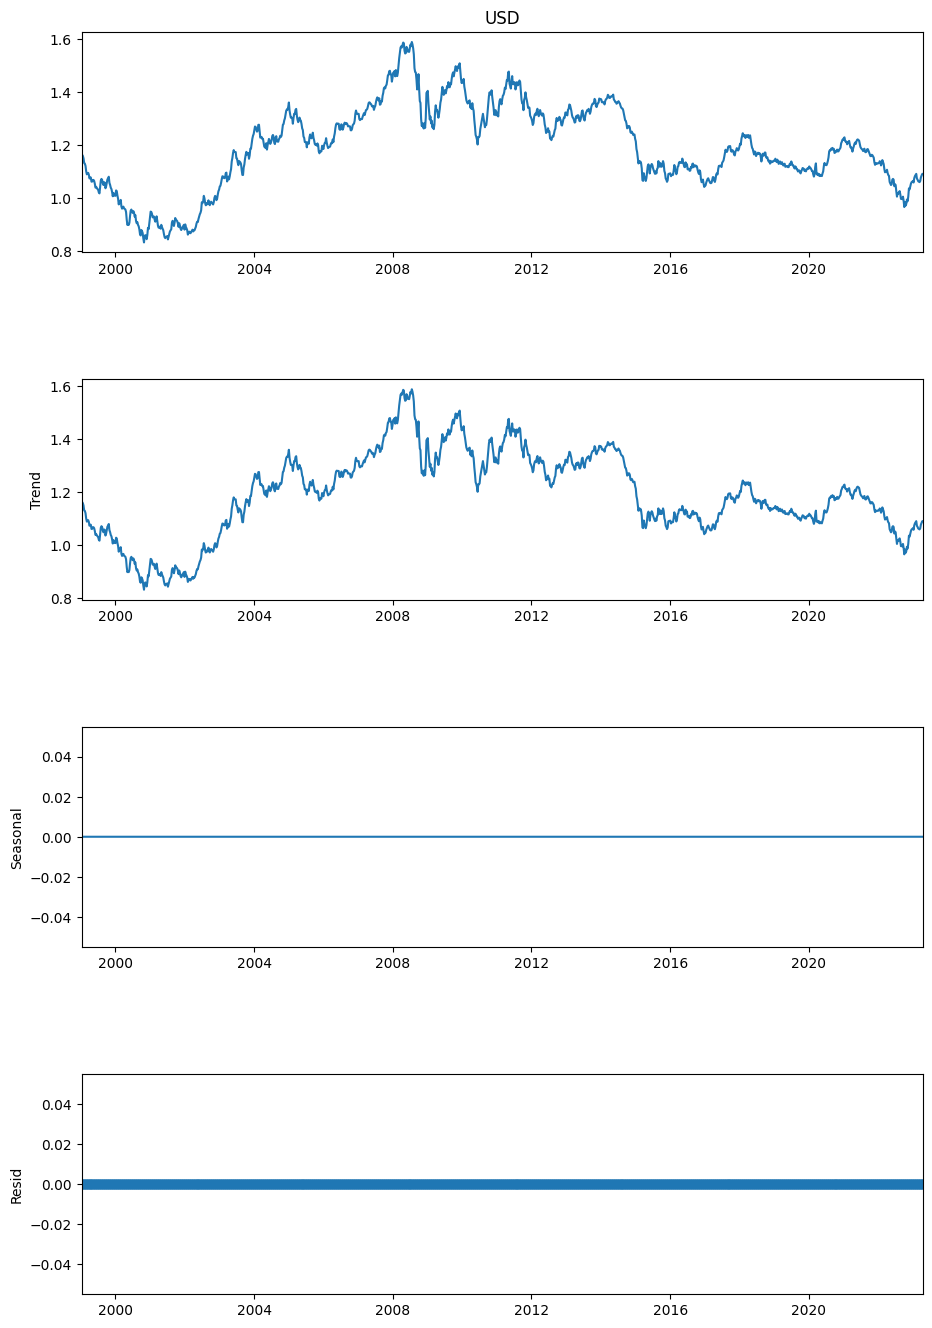

In [22]:
decompostion =sm.tsa.seasonal_decompose(df_usd, model='additive', period=1)
fig=decompostion.plot()
fig.set_size_inches(10,15)
plt.show()

## Differenecing

If original series is nonstaintaionary, differencing might be needed.
Let's try it out on the training dataset and plot the new series,I use the current observation minus the previous observation to get the new series, also use the drop na method since the first observation has no previous observation to subtract so its difference is missing.

In [23]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data.diff()
diff_train_data = diff_train_data.dropna() 

print('############# Raw Data ##############')
print(train_data)
print ('########### Differenced Data ###########')
print(diff_train_data)

############# Raw Data ##############
Date
1999-01-10    1.17226
1999-01-17    1.16224
1999-01-24    1.15884
1999-01-31    1.14978
1999-02-07    1.13134
               ...   
2021-12-26    1.12992
2022-01-02    1.13212
2022-01-09    1.13132
2022-01-16    1.13868
2022-01-23    1.13602
Name: USD, Length: 1203, dtype: float64
########### Differenced Data ###########
Date
1999-01-17   -0.01002
1999-01-24   -0.00340
1999-01-31   -0.00906
1999-02-07   -0.01844
1999-02-14   -0.00180
               ...   
2021-12-26   -0.00038
2022-01-02    0.00220
2022-01-09   -0.00080
2022-01-16    0.00736
2022-01-23   -0.00266
Name: USD, Length: 1202, dtype: float64


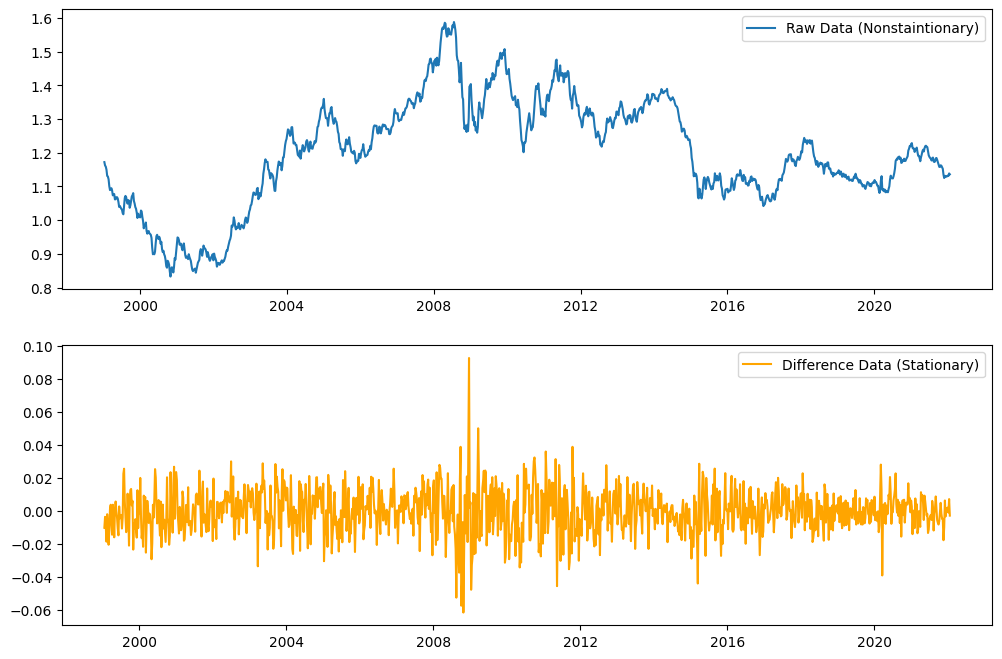

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data)
plt.legend(['Raw Data (Nonstaintionary)'])
plt. subplot(212)
plt.plot(diff_train_data,'orange') #first difference(t-(t-1))
plt.legend(['Difference Data (Stationary)'])
plt.show()

We can see the first difference time series doesn't show a strong trend anymore. It looks to be more stationary.

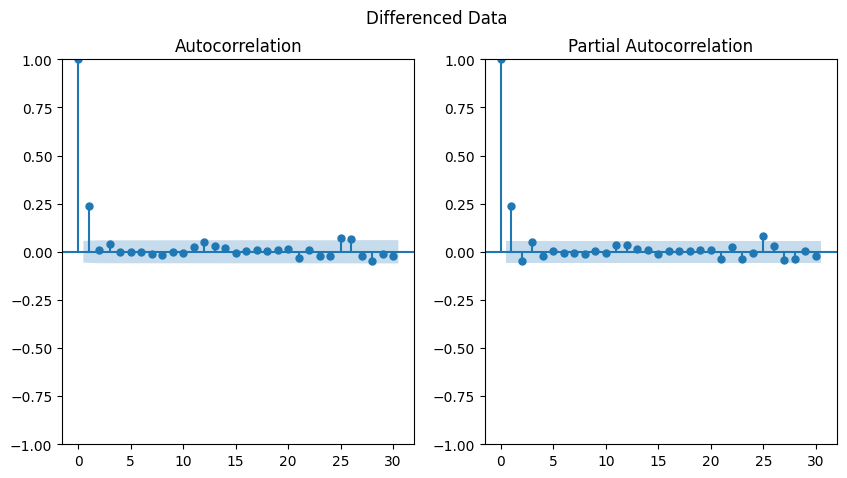

In [25]:
fig, ax=plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]); 

### Parameter search
Python packages provide functions to fit ARIMA models automatically.  
Let's try pmd arima python package that offers automatic ARIMA modelling based on the stats model library. Start from the training set I have trained, obtained in step 0 when exploring the dataset.
The auto arima function can help us automate the steps to fit in arima model. It will generate the optimal model based on its criteria.

In [26]:
#pip install pmdarima

In [29]:
import pmdarima as pm
auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

I set two of its parameters to be false so they will consider all possible, non-seasonal models.

In [30]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1203
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3534.397
Date:                Fri, 21 Apr 2023   AIC                          -7062.794
Time:                        09:15:56   BIC                          -7047.518
Sample:                    01-10-1999   HQIC                         -7057.040
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.806e-05      0.000     -0.082      0.934      -0.001       0.001
ma.L1          0.2483      0.021     12.054      0.000       0.208       0.289
sigma2         0.0002   4.44e-06     36.758      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               346.94
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

By default the auto process uses unit root test to select the value of parameter d
Then uses AIC information criteria to determine the values of p and q

#### Best model:  ARIMA(0,1,1)(0,0,0)[0]  

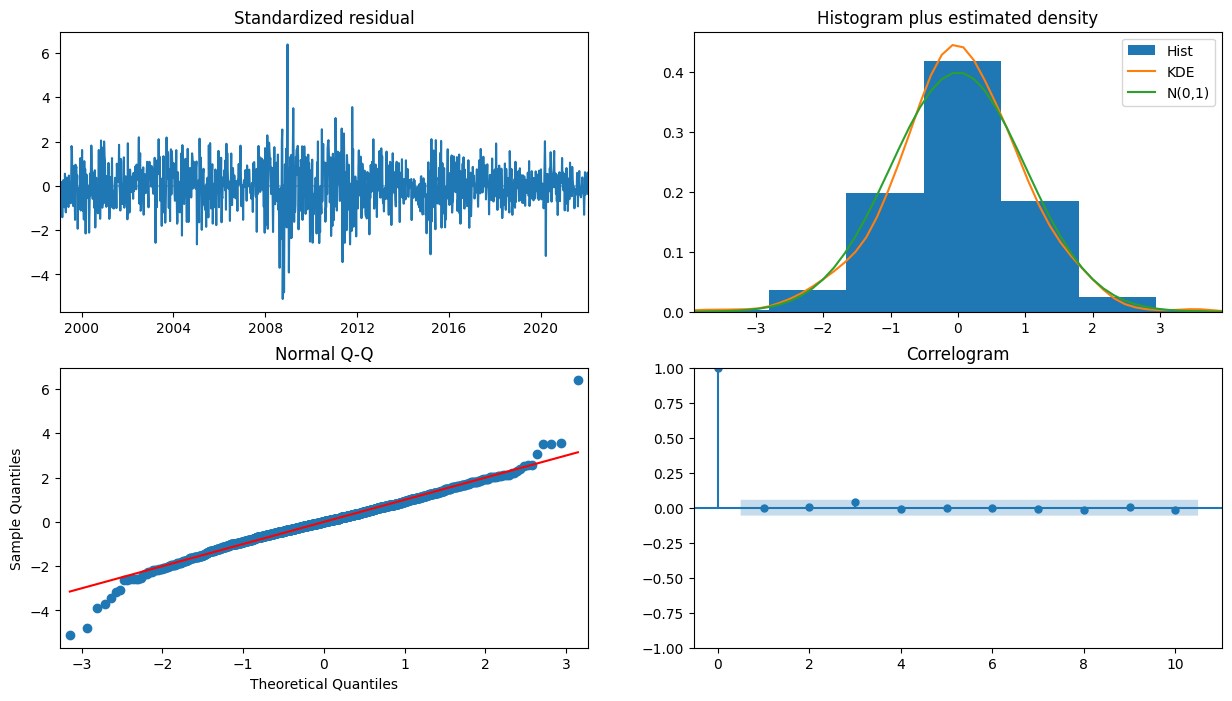

In [31]:
auto_arima.plot_diagnostics(figsize=(15,8))
plt.show()

The residuals look random in general and the density looks normally distributed with a mean of around 0

### Use model to forecase - ARIMA

In [53]:
prediction, confint = auto_arima.predict(n_periods=len(test_data),return_conf_int=True )
prediction

2022-01-30    1.134853
2022-02-06    1.134815
2022-02-13    1.134777
2022-02-20    1.134739
2022-02-27    1.134701
                ...   
2023-03-19    1.132608
2023-03-26    1.132570
2023-04-02    1.132532
2023-04-09    1.132494
2023-04-16    1.132456
Freq: W-SUN, Length: 64, dtype: float64

In [54]:
cf= pd.DataFrame(confint)

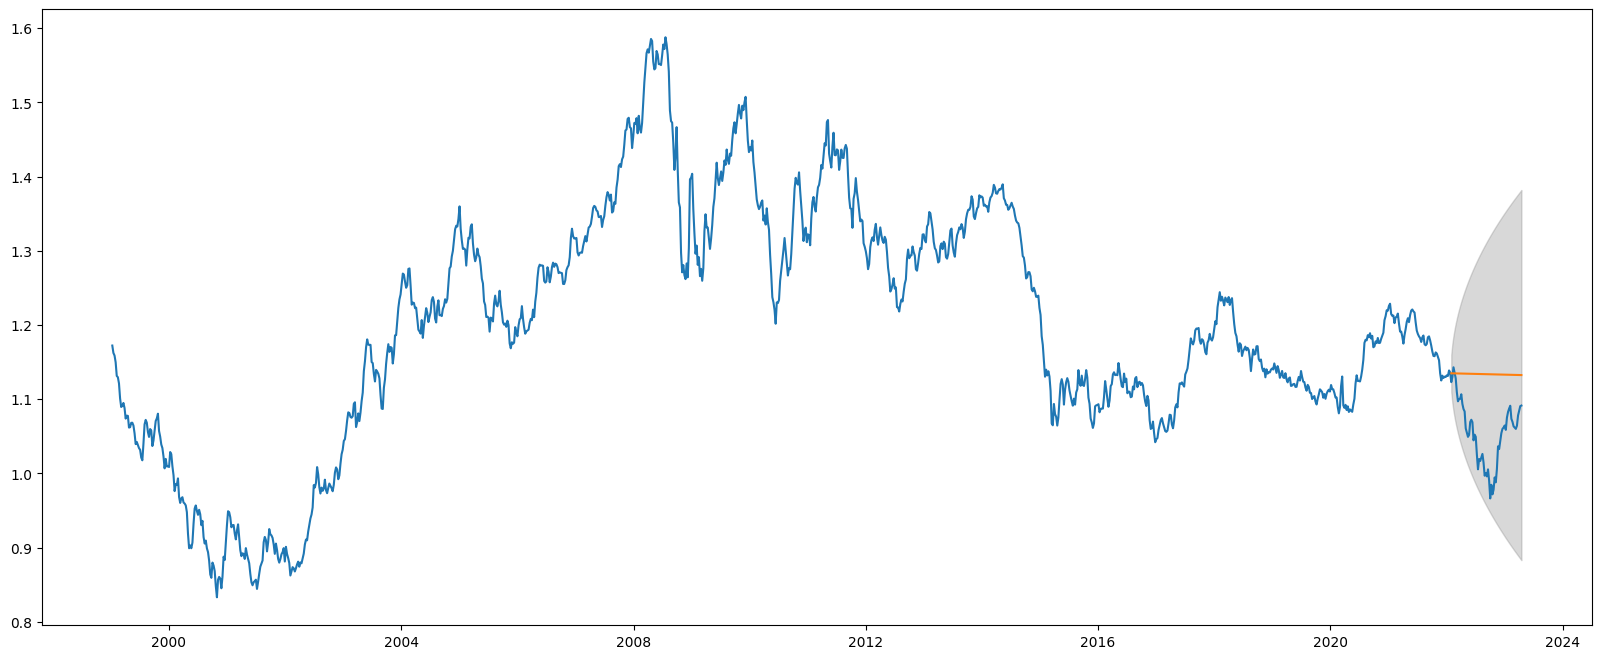

In [73]:
prediction_series = pd.Series(prediction,index=test_data.index)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(df5_weekly['USD'])
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [70]:
prediction_series.index[0]

Timestamp('2022-01-30 00:00:00')